In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    Theta,
    FFT
)
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mase, mse, mae, ope

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
dfs = pd.read_csv('data/stores.csv', low_memory=False)
dft = pd.read_csv('data/transactions.csv', low_memory=False)
dfu = pd.read_csv('data/users.csv', low_memory=False)

In [3]:
# Resample time to day
dft['dt'] = pd.to_datetime(dft['event_occurrence']).dt.to_period('D')

# Forecast Company
(3) Forecast GMV for the company as a whole for each date in the month of January 2022

### Daily GMV

In [4]:
# Total daily GMV
tsd = dft.groupby('dt')['amount'].sum()
tsd.index = tsd.index.to_timestamp()

In [5]:
tsd.head()

dt
2020-01-01    2633813
2020-01-02    2115625
2020-01-03    2110395
2020-01-04    2415564
2020-01-05    2346069
Freq: D, Name: amount, dtype: int64

In [6]:
# No missing dates so no need to interpolate
tsd.shape[0] - 1, tsd.index[-1] - tsd.index[0]

(730, Timedelta('730 days 00:00:00'))

### Trend, Seasonal composition

In [7]:
# Check the trend and seasonal component
res = seasonal_decompose(tsd, model='additive', extrapolate_trend='freq')

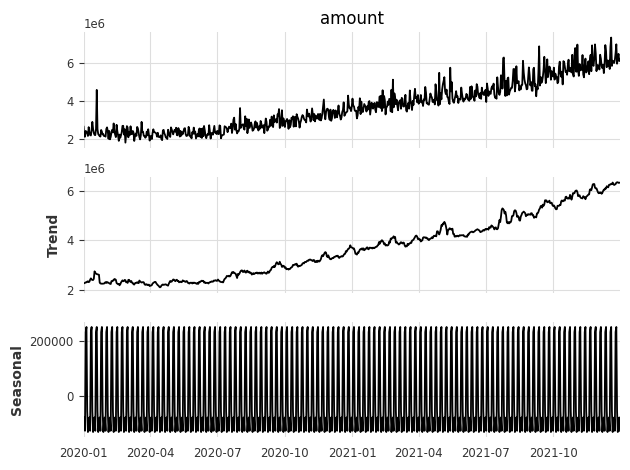

In [8]:
fig = res.plot(resid=False, weights=False)

<Axes: title={'center': 'seasonal'}, xlabel='dt'>

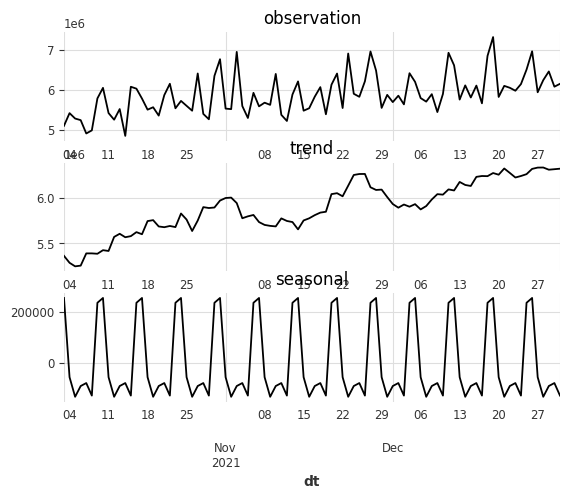

In [9]:
# Check for trend, season for recent days
ts_obs = pd.Series(res.observed, tsd.index)
ts_trend = pd.Series(res.trend, tsd.index)
ts_seasonal = pd.Series(res.seasonal, tsd.index)

n = 90
fig, axes  = plt.subplots(nrows=3)
ts_obs[-n:].plot(ax=axes[0], title='observation')
ts_trend[-n:].plot(ax=axes[1], title='trend')
ts_seasonal[-n:].plot(ax=axes[2], title='seasonal')

### Make datasets

In [10]:
# Split train/test
ts_train = tsd.loc[:'2021-11']
ts_test = tsd.loc['2021-12']

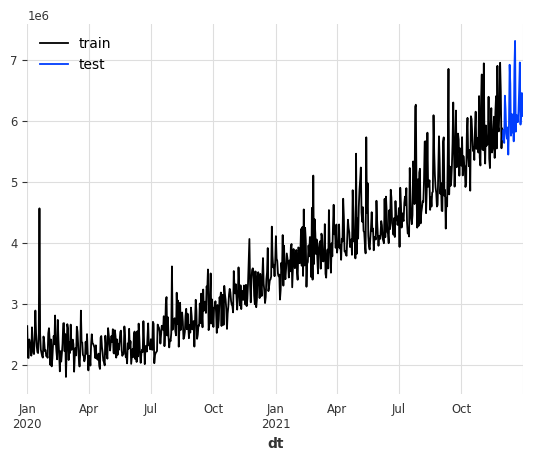

In [11]:
ts_train.plot(label='train')
ts_test.plot(label='test')
plt.legend()

### Models

In [12]:
# Compare 4 models from the darts library

def eval_model(model, ts_train, ts_test, name: str = None) -> tuple:
    """Calculate prediction and evaluation metrics."""
    if not name:
        name = type(model).__name__
    
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    setattr(y_pred, 'name', name)
    
    ss_eval = pd.Series({
        'mae': mae(actual_series=ts_test, pred_series=y_pred),
        "mse": mse(actual_series=ts_test, pred_series=y_pred),
        "mase": mase(actual_series=ts_test, pred_series=y_pred, insample=ts_train),
    })
    ss_eval.name = name

    return y_pred, ss_eval


def eval_multiple_models(ts_train, ts_test) -> tuple:
    """Evaluate for multiple models."""
    l_pred = []
    l_eval = []

    # Convert to darts timeseries
    # Train only last year data
    ts_train = TimeSeries.from_series(ts_train['2021-01':])
    ts_test = TimeSeries.from_series(ts_test)
    
    models = [
        NaiveSeasonal(K=1), # Last value
        NaiveSeasonal(K=7), # Weekly
        Theta(theta=2, seasonality_period=7, season_mode=SeasonalityMode.ADDITIVE),
        FFT(nr_freqs_to_keep=20, trend='poly', trend_poly_degree=2),
    ]
    for model in models:
        y_pred, ss_eval = eval_model(model, ts_train, ts_test)
        l_pred.append(y_pred)
        l_eval.append(ss_eval)
    
    df_eval = pd.DataFrame(l_eval).round(2)

    return l_pred, df_eval


# Create models evaluation data for validation and test datasets
l_pred, df_eval = eval_multiple_models(ts_train, ts_test)

No matching timestamp could be found, returning original TimeSeries.


,mae,mse,mase
NaiveSeasonal,357961.26,2.534707e+11,0.87
NaiveSeasonal,278704.35,1.147220e+11,0.68
Theta,238027.74,9.237924e+10,0.58
FFT,377378.07,1.942898e+11,0.92


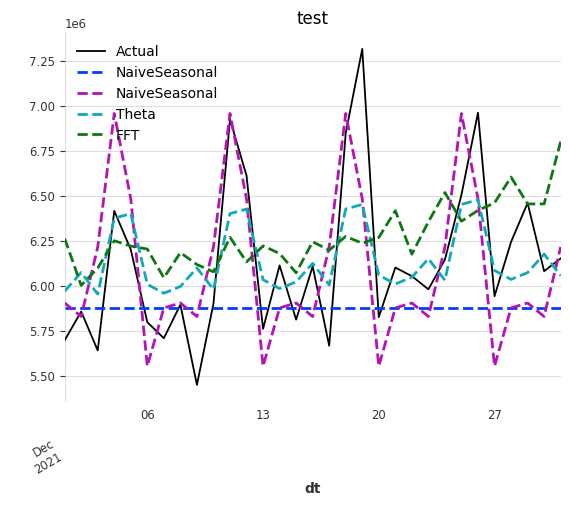

In [13]:
# Theta model performs best
display(df_eval)

ts_test.plot(label='Actual')
for y_pred in l_pred:
    y_pred.plot(label=y_pred.name, linestyle='--')
plt.legend()
_ = plt.title('test')

### Compare training window

In [14]:
def eval_train_window(ts_train, ts_test) -> tuple:
    """Evaluate for multiple models."""
    ts_test = TimeSeries.from_series(ts_test)
    
    l_pred = []
    l_eval = []
    
    model = Theta(theta=2, seasonality_period=7, season_mode=SeasonalityMode.ADDITIVE)
    for window in [30, 60, 90, 120, 240, 365]:
        ts_tr = TimeSeries.from_series(ts_train[-window:])
        y_pred, ss_eval = eval_model(model, ts_tr, ts_test, name=f'train {window} days')
        l_pred.append(y_pred)
        l_eval.append(ss_eval)
    
    df_eval = pd.DataFrame(l_eval).round(2)

    return l_pred, df_eval

# Create models evaluation data for validation and test datasets
l_pred, df_eval = eval_train_window(ts_train, ts_test)

,mae,mse,mase
train 30 days,275171.52,1.395839e+11,0.49
train 60 days,234127.33,9.896116e+10,0.47
train 90 days,211160.62,7.013416e+10,0.42
train 120 days,213889.42,7.007240e+10,0.45
train 240 days,230449.01,8.562980e+10,0.55
train 365 days,237119.30,9.227027e+10,0.60


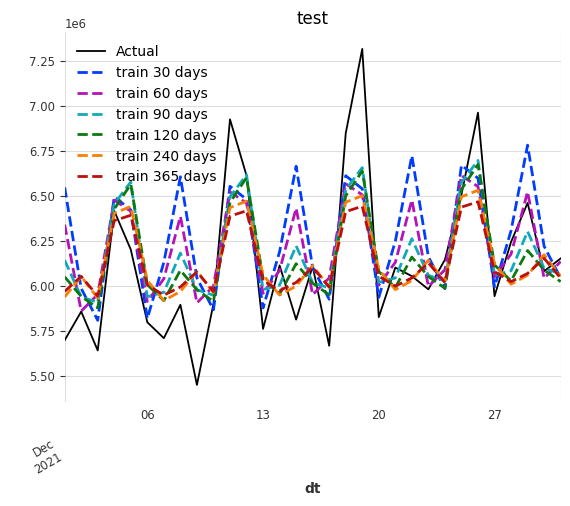

In [15]:
# Training on the last 90 days works best
display(df_eval)

ts_test.plot(label='Actual')
for y_pred in l_pred:
    y_pred.plot(label=y_pred.name, linestyle='--')
plt.legend()
_ = plt.title('test')

### Forecast

In [16]:
# Forecast with Theta model
model = Theta(theta=2, seasonality_period=7, season_mode=SeasonalityMode.ADDITIVE)

# Train on last 90 days
ts = TimeSeries.from_series(tsd[-90:])
model.fit(ts)
ts_pred = model.predict(31)

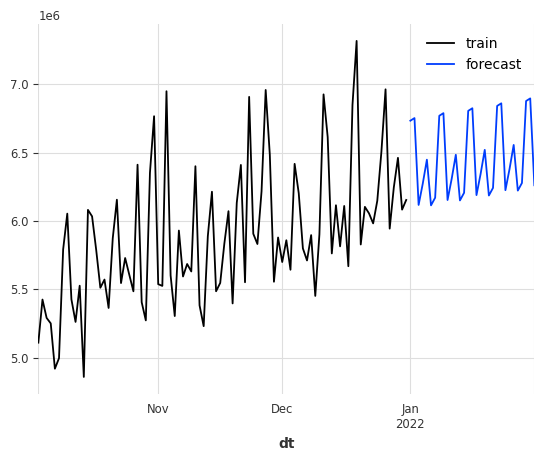

In [17]:
ts.pd_series().plot(label='train')
ts_pred.pd_series().plot(label='forecast')
_ = plt.legend()

In [18]:
# Make output
ts = ts_pred.pd_series().astype(int)
df = ts.to_frame('gmv').reset_index()
df.head()

,dt,gmv
0,2022-01-01,6734180
1,2022-01-02,6753260
2,2022-01-03,6117317
3,2022-01-04,6272629
4,2022-01-05,6448715


In [19]:
df.to_csv('output/forecast_company.csv', index=False)

# Conclusion
The Theta model can capture the weekly seasonal component and the upward trend. However it fails to capture the extremes.

### Improvement Steps
- Try other models from darts: Exponential Smoothening, ARIMA. And machine learning models.
- Predict for each store or each user and then sum the predictions.